# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt

In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    # train_period = ast.literal_eval(config.get("train_period"))
    # test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_tech data paths
    lst_df_tech_paths = ast.literal_eval(config.get("paths_df_tech_processed"))
    

In [4]:
# Import data 
path = lst_df_tech_paths[2]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df = df.dropna()

# **Split data**

In [7]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_train

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2022-02-07,34.60,11.80,7.39,14.80,23.890,17.020,39.851,35.60,27.966,24.200
2022-02-08,35.30,12.20,7.10,15.50,23.890,17.094,39.677,35.85,27.808,24.867
2022-02-09,35.60,12.45,7.20,15.80,23.537,17.757,39.720,35.05,28.602,24.734
2022-02-10,35.10,12.65,7.20,15.80,23.855,17.389,39.199,34.75,28.205,24.467
2022-02-11,35.10,12.40,7.26,16.45,23.996,17.389,39.199,35.30,28.403,24.400
...,...,...,...,...,...,...,...,...,...,...
2023-03-08,11.20,7.55,3.49,4.14,14.928,8.516,19.050,25.35,14.700,18.150
2023-03-09,11.20,7.81,3.49,4.30,15.098,8.728,19.050,26.50,14.700,18.200
2023-03-10,11.25,7.64,3.40,4.18,15.056,8.559,19.050,26.00,14.500,18.300


## **Gatev Data Normalization**

In [10]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [11]:
df_cum_daily_returns_train

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2022-02-08,2.023121,3.389831,-3.924222,4.729730,0.000000,0.434783,-0.436626,0.702247,-0.564972,2.756198
2022-02-09,2.890173,5.508475,-2.571042,6.756757,-1.477606,4.330200,-0.328724,-1.544944,2.274190,2.206612
2022-02-10,1.445087,7.203390,-2.571042,6.756757,-0.146505,2.168038,-1.636094,-2.387640,0.854609,1.103306
2022-02-11,1.445087,5.084746,-1.759134,11.148649,0.443700,2.168038,-1.636094,-0.842697,1.562612,0.826446
2022-02-12,1.445087,5.084746,-1.759134,11.148649,0.443700,2.168038,-1.636094,-0.842697,1.562612,0.826446
...,...,...,...,...,...,...,...,...,...,...
2023-03-08,-67.630058,-36.016949,-52.774019,-72.027027,-37.513604,-49.964747,-52.196934,-28.792135,-47.436172,-25.000000
2023-03-09,-67.630058,-33.813559,-52.774019,-70.945946,-36.802009,-48.719154,-52.196934,-25.561798,-47.436172,-24.793388
2023-03-10,-67.485549,-35.254237,-53.991881,-71.756757,-36.977815,-49.712103,-52.196934,-26.966292,-48.151327,-24.380165


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_DXG và adClose_HQC: 219.0
Khoảng cách Euclide của adClose_DXG và adClose_VND: 224.3
Khoảng cách Euclide của adClose_HQC và adClose_ITA: 233.6
Khoảng cách Euclide của adClose_HQC và adClose_SHB: 251.5
Khoảng cách Euclide của adClose_HQC và adClose_SSI: 229.5
Khoảng cách Euclide của adClose_MBB và adClose_STB: 214.1
Khoảng cách Euclide của adClose_MBB và adClose_VND: 252.4
Khoảng cách Euclide của adClose_MBB và adClose_VPB: 154.8
Khoảng cách Euclide của adClose_SHB và adClose_SSI: 137.8
Khoảng cách Euclide của adClose_SHB và adClose_STB: 182.7
[['adClose_DXG', 'adClose_HQC'], ['adClose_DXG', 'adClose_VND'], ['adClose_HQC', 'adClose_ITA'], ['adClose_HQC', 'adClose_SHB'], ['adClose_HQC', 'adClose_SSI'], ['adClose_MBB', 'adClose_STB'], ['adClose_MBB', 'adClose_VND'], ['adClose_MBB', 'adClose_VPB'], ['adClose_SHB', 'adClose_SSI'], ['adClose_SHB', 'adClose_STB']]


In [15]:
gatev_pairs

[['adClose_DXG', 'adClose_HQC'],
 ['adClose_DXG', 'adClose_VND'],
 ['adClose_HQC', 'adClose_ITA'],
 ['adClose_HQC', 'adClose_SHB'],
 ['adClose_HQC', 'adClose_SSI'],
 ['adClose_MBB', 'adClose_STB'],
 ['adClose_MBB', 'adClose_VND'],
 ['adClose_MBB', 'adClose_VPB'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_STB']]

# **Cointegration Approach**

## **Data Transformation**

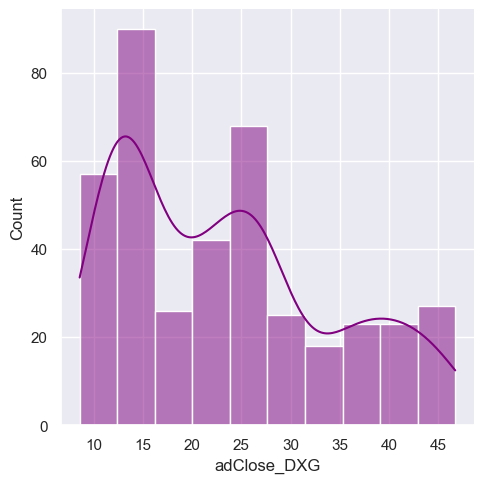

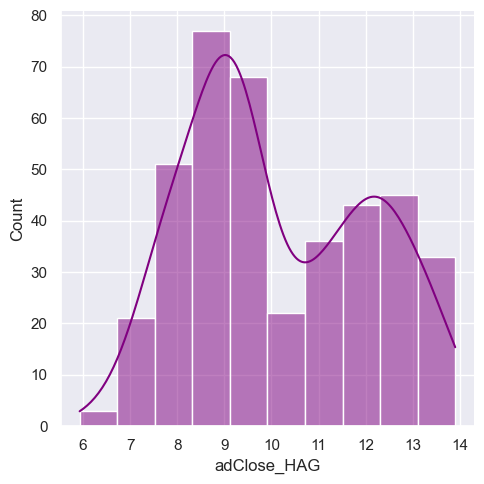

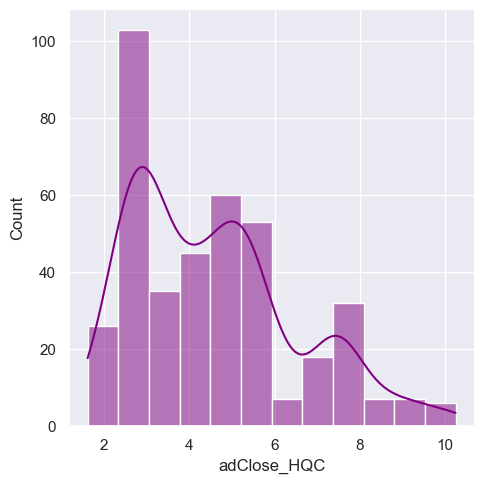

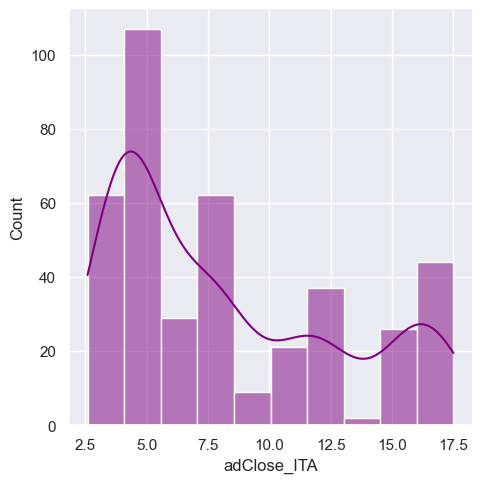

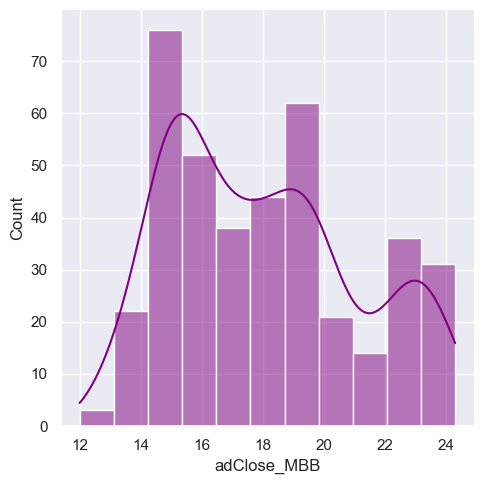

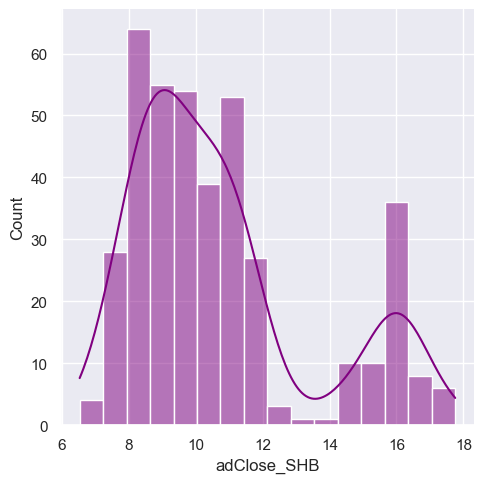

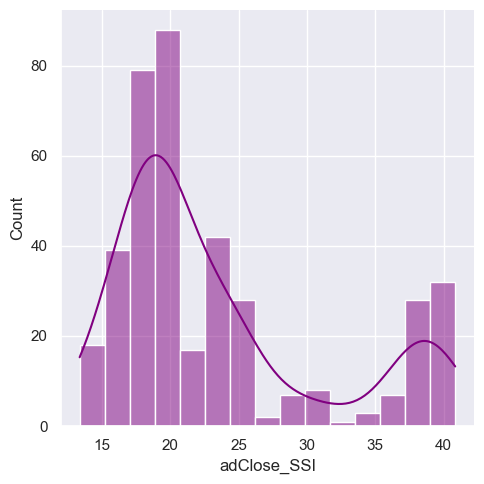

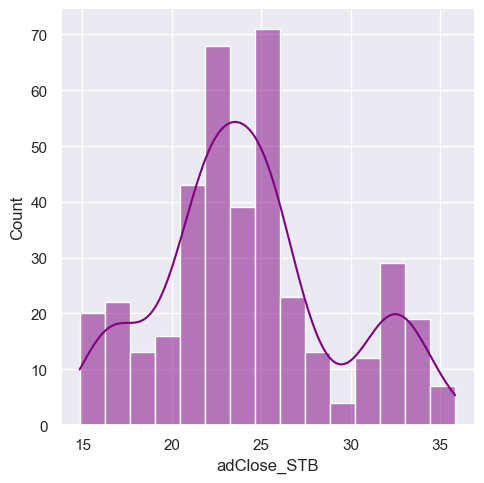

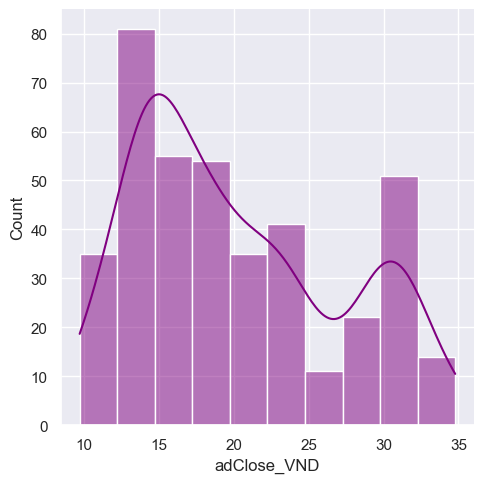

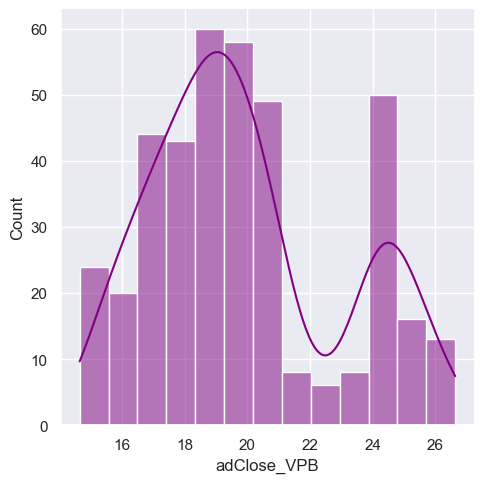

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [17]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_DXG,1
1,adClose_HAG,1
2,adClose_HQC,1
3,adClose_ITA,1
4,adClose_MBB,1
5,adClose_SHB,1
6,adClose_SSI,1
7,adClose_STB,1
8,adClose_VND,1
9,adClose_VPB,1


In [20]:
# Only use time series that have order of integration is 1 
df_order_of_integration_ts = tsa_snp.find_integration_order(df_train_transformed)
lst_non_stationary_ts = df_order_of_integration_ts[
    df_order_of_integration_ts['Integration Order'] == 1
]['Column Name'].tolist()

# Keep those stocks which have order of integration is 1 
df_train_transformed = df_train_transformed[lst_non_stationary_ts]

# Print df
df_train_transformed

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2022-02-07,3.543854,2.468100,2.000128,2.694627,3.173460,2.834389,3.685147,3.572346,3.330989,3.186353
2022-02-08,3.563883,2.501436,1.960095,2.740840,3.173460,2.838728,3.680772,3.579344,3.325324,3.213542
2022-02-09,3.572346,2.521721,1.974081,2.760010,3.158574,2.876780,3.681855,3.556776,3.353477,3.208179
2022-02-10,3.558201,2.537657,1.974081,2.760010,3.171994,2.855838,3.668651,3.548180,3.339499,3.197325
2022-02-11,3.558201,2.517696,1.982380,2.800325,3.177887,2.855838,3.668651,3.563883,3.346495,3.194583
...,...,...,...,...,...,...,...,...,...,...
2023-03-08,2.415914,2.021548,1.249902,1.420696,2.703239,2.141947,2.947067,3.232779,2.687847,2.898671
2023-03-09,2.415914,2.055405,1.249902,1.458615,2.714562,2.166536,2.947067,3.277145,2.687847,2.901422
2023-03-10,2.420368,2.033398,1.223775,1.430311,2.711777,2.146983,2.947067,3.258097,2.674149,2.906901


## **Engle - Grange Method**

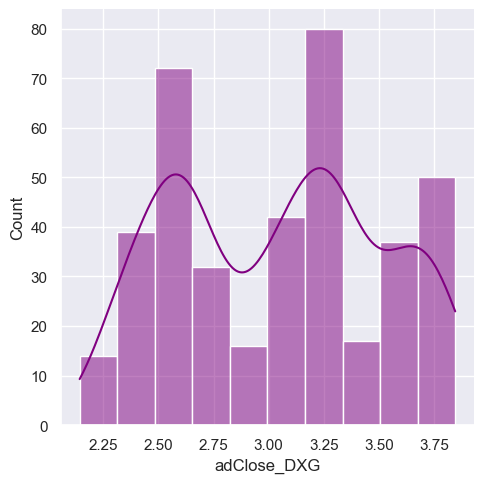

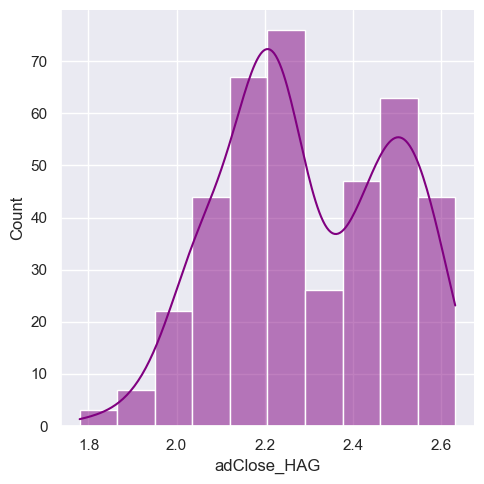

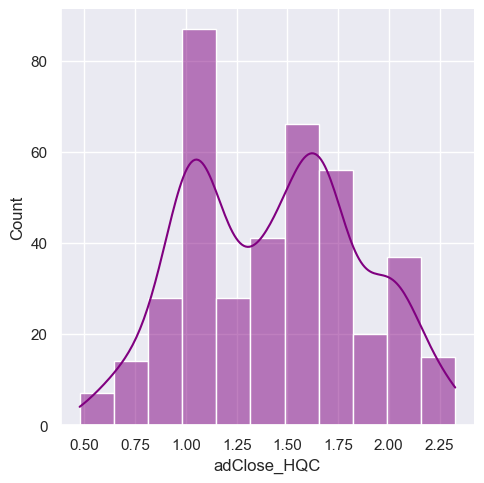

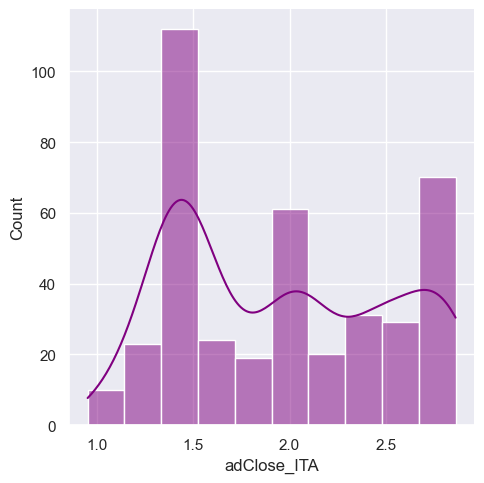

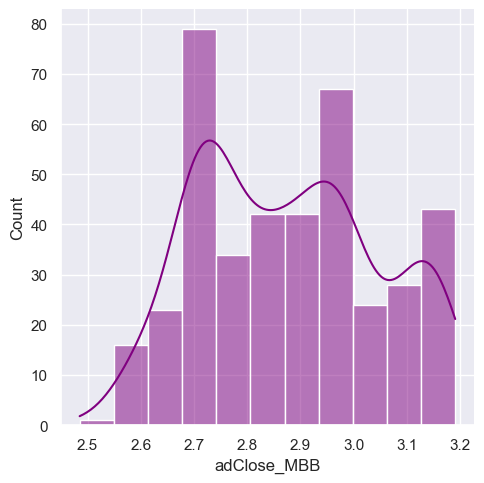

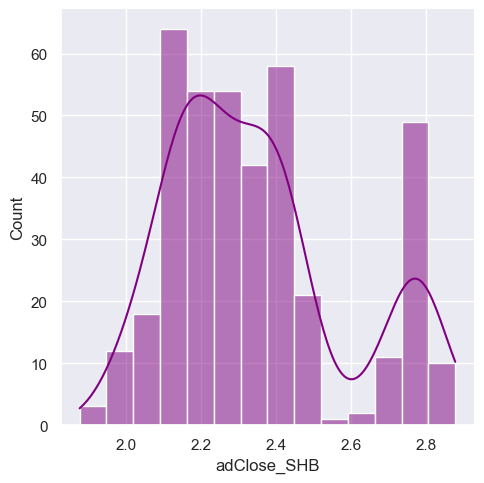

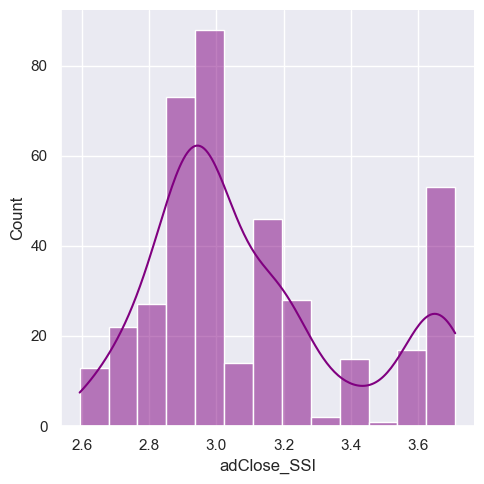

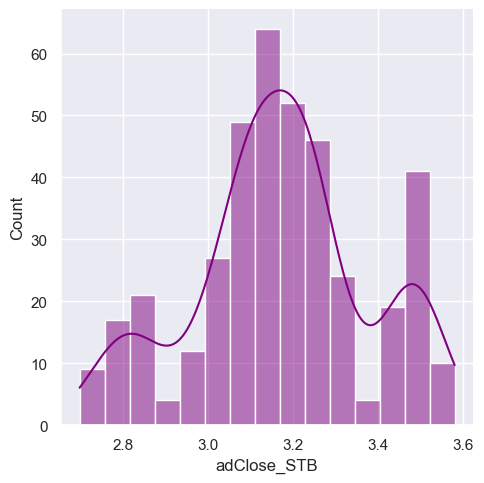

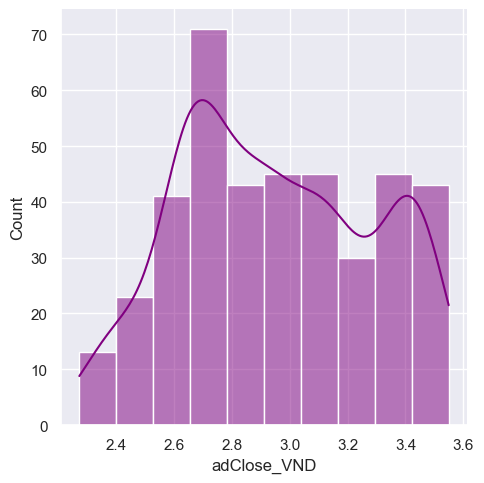

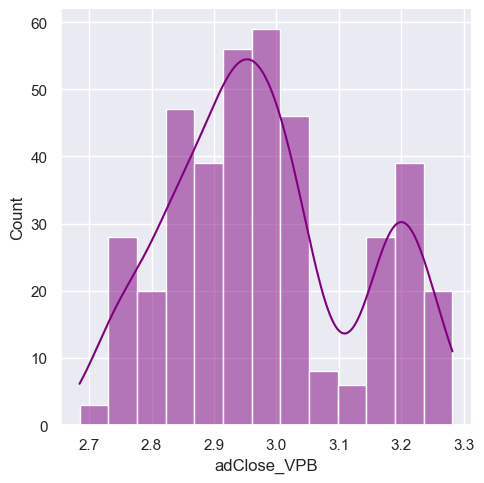

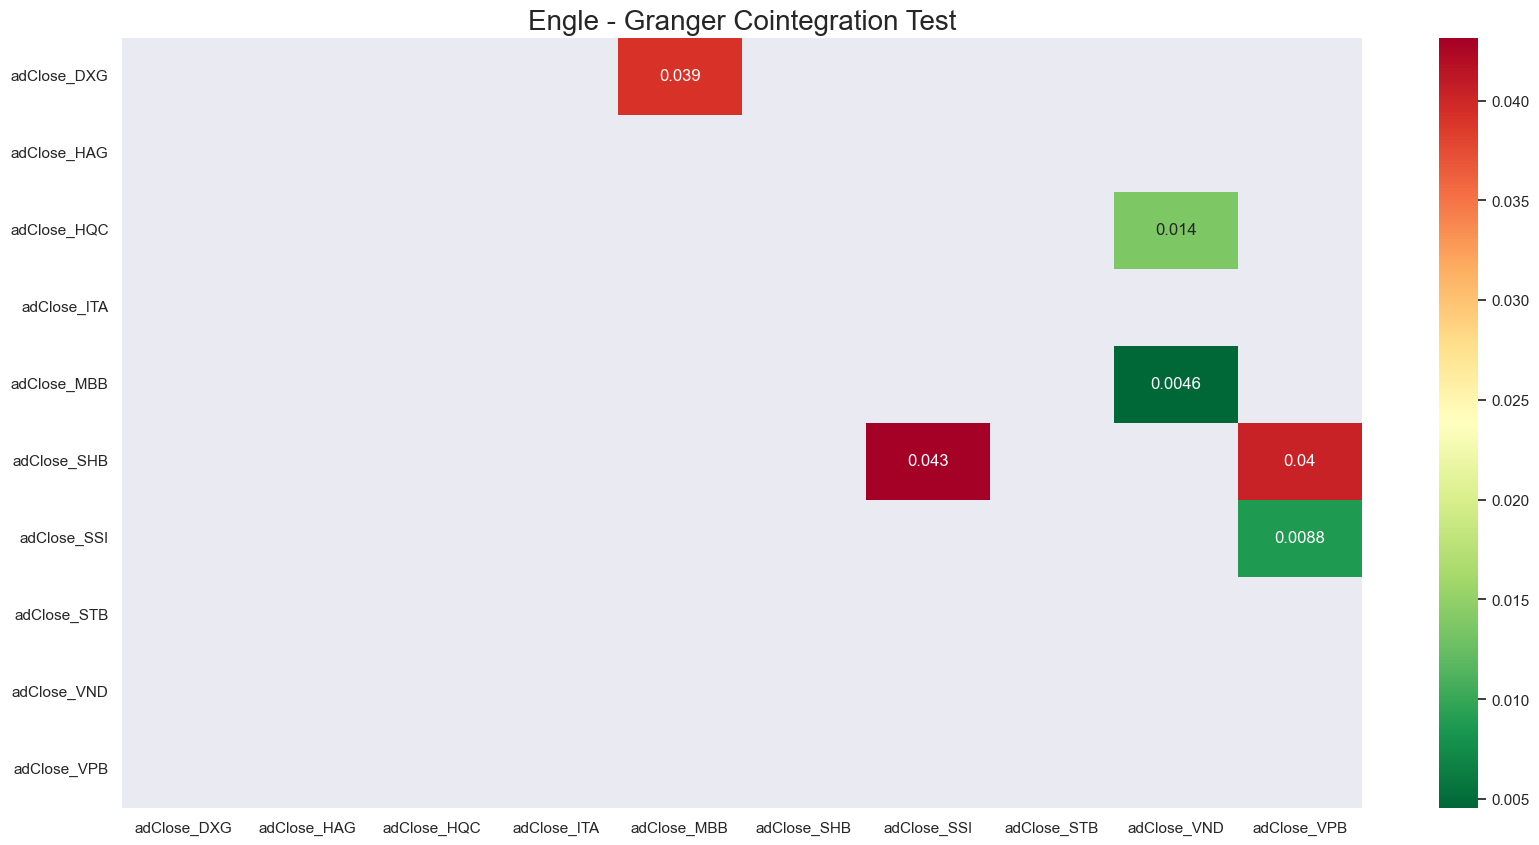

In [21]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [22]:
eg_pairs 

[['adClose_DXG', 'adClose_MBB'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_MBB', 'adClose_VND'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_VPB'],
 ['adClose_SSI', 'adClose_VPB']]

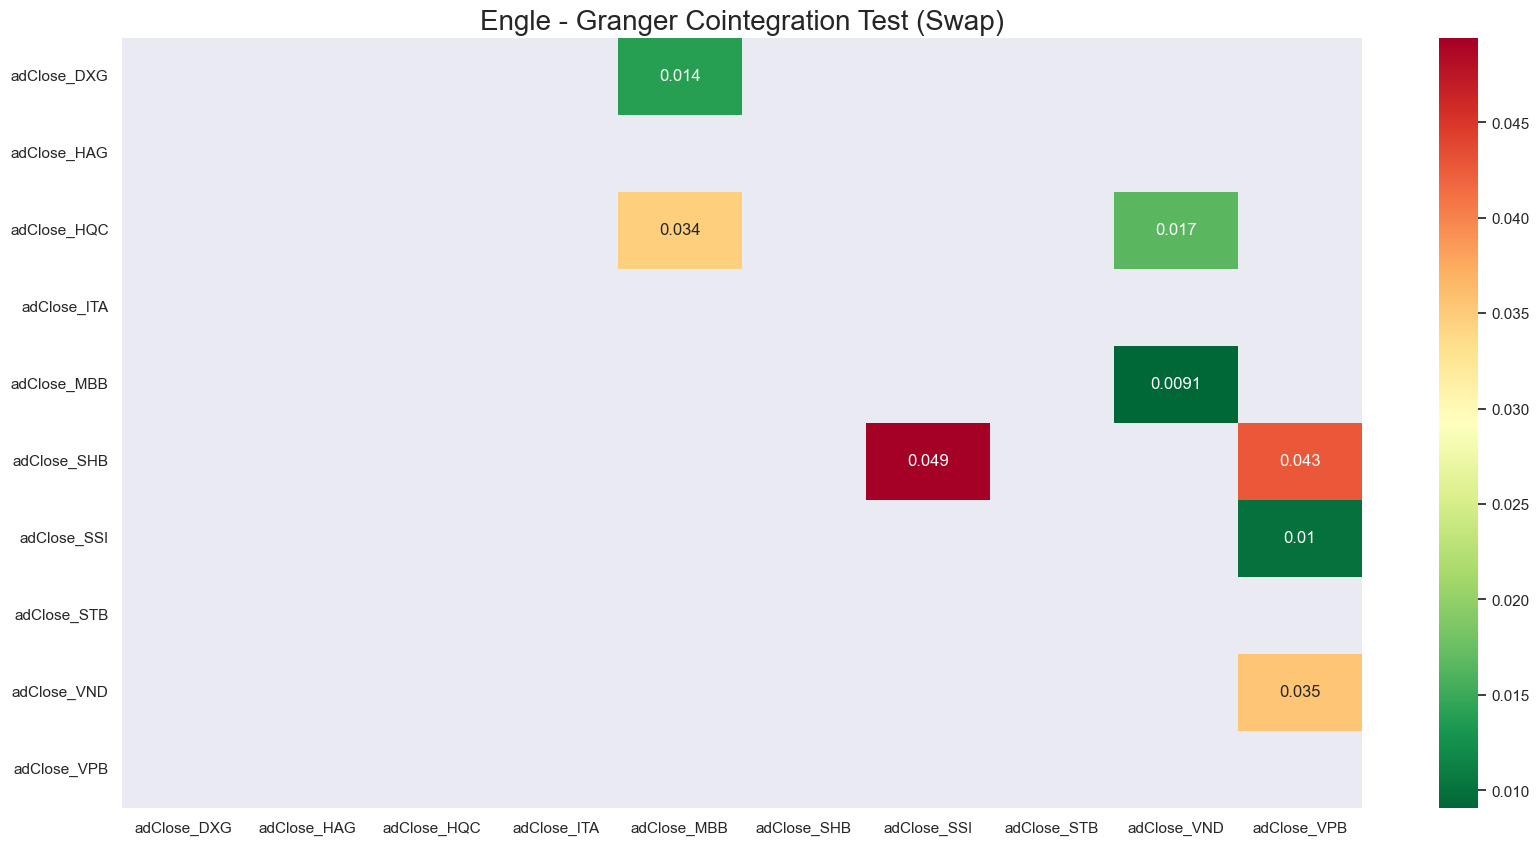

In [23]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed)

In [24]:
eg_pairs_swap

[['adClose_DXG', 'adClose_MBB'],
 ['adClose_HQC', 'adClose_MBB'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_MBB', 'adClose_VND'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_VPB'],
 ['adClose_SSI', 'adClose_VPB'],
 ['adClose_VND', 'adClose_VPB']]

## **Johansen Method**

In [25]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [26]:
johansen_pairs

[['adClose_DXG', 'adClose_MBB'],
 ['adClose_DXG', 'adClose_SHB'],
 ['adClose_DXG', 'adClose_STB'],
 ['adClose_MBB', 'adClose_SHB'],
 ['adClose_MBB', 'adClose_VND'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_VND'],
 ['adClose_SHB', 'adClose_VPB'],
 ['adClose_SSI', 'adClose_VND'],
 ['adClose_SSI', 'adClose_VPB'],
 ['adClose_STB', 'adClose_VND']]

# **Result Summary**

In [27]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [28]:
df_pairs_formation_train

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_DXG,adClose_HQC,x,,,,1
1,adClose_DXG,adClose_MBB,,x,x,x,3
2,adClose_DXG,adClose_SHB,,,,x,1
3,adClose_DXG,adClose_STB,,,,x,1
4,adClose_DXG,adClose_VND,x,,,,1
5,adClose_HQC,adClose_ITA,x,,,,1
6,adClose_HQC,adClose_MBB,,,x,,1
7,adClose_HQC,adClose_SHB,x,,,,1
8,adClose_HQC,adClose_SSI,x,,,,1
9,adClose_HQC,adClose_VND,,x,x,,2


In [29]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//tech//tech_pairs_formation_third_period_{hdt.today_date_to_digits()}.csv"
    )